In [22]:
# prepare libraries & data

import matplotlib.pyplot as plt
import numpy as np
import imageio
import csv

descriptions_train_dir = 'data/descriptions_train/'
features_train_dir = 'data/features_train/'
images_train_dir = 'data/images_train/'
tags_train_dir = 'data/tags_train/'

def read_example(n):
    print('Descriptions:')
    descriptions_train_file = open(descriptions_train_dir + str(n) + '.txt', 'r') 
    print(descriptions_train_file.read())
    
    print('Tags:')
    tags_train_file = open(tags_train_dir + str(n) + '.txt', 'r') 
    print(tags_train_file.read())
    
    im = imageio.imread(images_train_dir + str(n) + '.jpg')
    plt.imshow(im)

2049
2049
2049
2049
2049
2049


In [299]:
features_resnet1000intermediate_train = np.zeros((10000, 2048)) # resnet feature

filename = 'features_resnet1000intermediate_train.csv'
with open(features_train_dir + filename) as f:
    reader = csv.reader(f)
    for line in reader:
        index = int(line[0][13:].split('.')[0])
        features_resnet1000intermediate_train[index] = line[1:]
features_resnet1000intermediate_train.astype(float)

array([[1.03315091, 0.14875449, 0.04642047, ..., 0.07316806, 0.41725951,
        0.19742125],
       [0.23184368, 0.12003349, 0.09078766, ..., 0.27578694, 3.49657249,
        0.06475818],
       [0.62282479, 0.25091803, 0.68479973, ..., 0.46948081, 0.70399392,
        0.23659612],
       ...,
       [0.05613672, 1.93112803, 0.23134135, ..., 0.36287165, 0.12175643,
        0.31296232],
       [1.04675007, 0.54812443, 0.48379216, ..., 0.17267197, 0.93013376,
        0.42781889],
       [0.16653799, 0.85952431, 0.16225892, ..., 0.32290319, 0.54848814,
        0.17039269]])

In [167]:
descriptions_test_dir = 'data/descriptions_test/'
features_test_dir = 'data/features_test/'
images_test_dir = 'data/images_test/'
tags_test_dir = 'data/tags_test/'

def read_test_example(n):
    print('Descriptions:')
    descriptions_test_file = open(descriptions_test_dir + str(n) + '.txt', 'r') 
    print(descriptions_test_file.read())
    
    print('Tags:')
    tags_test_file = open(tags_test_dir + str(n) + '.txt', 'r') 
    print(tags_test_file.read())
    
    im = imageio.imread(images_test_dir + str(n) + '.jpg')
    plt.imshow(im)

Descriptions:
A large slice of angel food cake sitting on top of a plate.
A small plate contains a large slice of cake. 
A quarter of a cake on a plate
A large piece of yellow cake sits on a plate.
A large slab of sponge cake sits upon a flowery plate.

Tags:
animal:cow



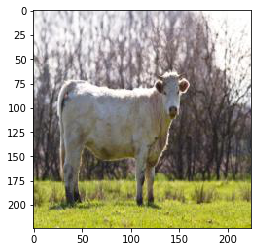

In [169]:
read_test_example(1)

Descriptions:
A group of kids at table around a cake.
A group of kids around a table with a cake.
A group of kids watching a woman light a candle.
A group of young children standing around a cake.
little kids sitting around a table that has a birthday cake on it

Tags:
furniture:dining table
person:person
kitchen:cup
food:cake



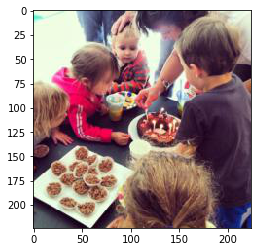

In [175]:
read_example(18)

In [267]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string

table = str.maketrans('', '', string.punctuation)
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def parse_description(i):
    descriptions_train_file = open(descriptions_train_dir + str(i) + '.txt', 'r') 
    lines = descriptions_train_file.read()
    # print(lines)
    
    nouns = []
    for word,pos in nltk.pos_tag(nltk.word_tokenize(lines)):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns.append(word)
            
    words = [w.lower() for w in nouns]
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    words = [stemmer.stem(w) for w in words]
    # words = [lemmatizer.lemmatize(w) for w in words]
    
    # TODO remain nouns

    return ' '.join(words)
    
parse_description(1)

'bowl soup carrot shrimp noodl food bowl soup carrot shrimp chopstick bowl ramen someon bowl asian noodl soup shrimp carrot'

# Bag of words

In [268]:
from sklearn.feature_extraction.text import CountVectorizer

training_size = 10000

training_descriptions = []
for i in range(training_size):
    if i % 1000 == 0:
        print(i)
    training_descriptions.append(parse_description(i))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [308]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(training_descriptions)
X = X.toarray()
print( len(vectorizer.get_feature_names()) )
print( vectorizer.get_feature_names()[0:50] )

4923
['abdomen', 'abil', 'abll', 'aboard', 'abook', 'abou', 'abraham', 'abreast', 'abund', 'abyss', 'acacia', 'accent', 'access', 'accessori', 'accid', 'account', 'ace', 'acket', 'aclock', 'acm', 'acorn', 'across', 'act', 'action', 'activ', 'actor', 'ad', 'add', 'addit', 'address', 'adjac', 'adjust', 'adolesc', 'adult', 'adventur', 'advertis', 'aer', 'aeroplan', 'afar', 'affair', 'affect', 'afghan', 'afield', 'africa', 'afro', 'afterburn', 'afternoon', 'agaist', 'age', 'agenc']


# MLP

In [271]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

def mlp(X, y, test):
    clf = MLPRegressor(solver='sgd', alpha=1e-5, max_iter=2000,
                    hidden_layer_sizes=(2048, 1024, 1024), random_state=1)
    clf.fit(X, y)
    return clf.predict(test)

# Get top 20

In [364]:
import heapq

def closest_20_neighbors(target, candid):
    dist2index = {}
    idx = 0
    
    pq = []
    for c in candid:
        d = np.linalg.norm(target - c)
        dist2index[d] = idx
        pq.append(d)
        idx += 1

    res = []
    for d in heapq.nsmallest(20, pq):
        res.append(dist2index[d])
    return res

# Cross validation

In [379]:
from random import shuffle
label = [i for i in range(10000)]
shuffle(label)

y = features_resnet1000intermediate_train

# wordvec_train = np.zeros((8000, len(vectorizer.get_feature_names())))
wordvec_train = np.zeros((8000, pca_components))
feature_train = np.zeros((8000, 2048))
# wordvec_test = np.zeros((2000, len(vectorizer.get_feature_names())))
wordvec_test = np.zeros((2000, pca_components))
feature_test = np.zeros((2000, 2048))

y_label = []

for i in range(8000):
    wordvec_train[i] = X_pca[label[i]]
    feature_train[i] = y[label[i]]
for i in range(2000):
    wordvec_test[i] = X_pca[label[i + 8000]]
    feature_test[i] = y[label[i + 8000]]
    y_label.append(label[i])

In [238]:
feature_predict = mlp(wordvec_train, feature_train, wordvec_test)
print('predict finished')

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


predict finished


In [239]:
idx = 0
score_sum = 0
for y_p in feature_predict:
    top_20 = closest_20_neighbors(y_p, feature_test)
    j = 1
    for i in top_20:
        if i == idx:
            # MAP@20
            score_sum += float(21 - j) / 20.0
            break
        j += 1
    idx += 1
    if idx % 100 == 0:
        print(idx)
score = score_sum / 2000.0
print(score)

KeyboardInterrupt: 

In [181]:
print(feature_predict[0])

[0.47319756 0.4687879  0.38619005 ... 0.35677502 0.77253476 0.55194069]


In [301]:
print(y.shape)
print(X.shape)

(10000, 2048)
(10000, 4923)


# Reduce dimension

In [ ]:
import tensorflow as tf



In [378]:
from sklearn.decomposition import PCA

pca_components = 1024
pca = PCA(n_components=pca_components)
X_pca = pca.fit_transform(X)
print(X_pca[0])

[ 0.60180886  0.14567559 -1.49503461 ...  0.00944589 -0.02258241
 -0.00586142]


# Training with full set

In [388]:
clf = MLPRegressor(solver='sgd', alpha=1e-5, max_iter=2000,
                hidden_layer_sizes=(4096, 4096, 2048), random_state=1)
clf.fit(y, X_pca)
print("finished.")

finished.


In [389]:
wordvec_predict = clf.predict(feature_test)

idx = 0
score_sum = 0
tops = []
for x_p in wordvec_test:
    top_20 = closest_20_neighbors(x_p, wordvec_predict)
    tops.append(top_20)
    j = 1
    for i in top_20:
        if i == idx:
            # MAP@20
            score_sum += float(21 - j) / 20.0
            break
        j += 1
    idx += 1
    if idx % 100 == 0:
        print(idx)
    
score = score_sum / 2000.0
print(score)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
0.7776750000000024


In [390]:
for i in range(10):
    print(tops[i][:10])

[1471, 1848, 1144, 1199, 1775, 658, 1043, 178, 464, 1929]
[1, 1713, 765, 1667, 1588, 1733, 1195, 1757, 898, 1819]
[678, 1130, 1900, 218, 1860, 1249, 2, 681, 75, 1680]
[1158, 933, 1408, 1653, 1604, 990, 988, 306, 971, 1880]
[4, 307, 465, 867, 1964, 1020, 1016, 878, 210, 855]
[568, 5, 1130, 678, 846, 1860, 1900, 681, 1586, 886]
[6, 1872, 856, 631, 627, 1368, 574, 356, 411, 18]
[931, 7, 1287, 743, 1929, 204, 1775, 1069, 464, 977]
[8, 283, 282, 80, 813, 491, 907, 119, 1690, 875]
[9, 514, 621, 1311, 670, 256, 1663, 1562, 481, 360]


In [391]:
word2index = {}

idx = 0
for w in vectorizer.get_feature_names():
    word2index[w] = idx
    idx += 1

print(len(word2index))

4923


In [392]:
descriptions_test_dir = 'data/descriptions_test/'
features_test_dir = 'data/features_test/'
images_test_dir = 'data/images_test/'
tags_test_dir = 'data/tags_test/'

table = str.maketrans('', '', string.punctuation)
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def parse_test_description(i):
    descriptions_test_file = open(descriptions_test_dir + str(i) + '.txt', 'r') 
    lines = descriptions_test_file.read()
    # print(lines)
    
    nouns = []
    for word,pos in nltk.pos_tag(nltk.word_tokenize(lines)):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns.append(word)
    
    words = [w.lower() for w in nouns]
    words = [w for w in words if not w in stop_words] # strip stopword
    words = [stemmer.stem(w) for w in words] # stem
    
    return words
    
test_size = 2000
X_real_test = np.zeros((test_size, len(vectorizer.get_feature_names())))

for i in range(test_size):
    words = parse_test_description(i)
    for w in words:
        if w in word2index:
            X_real_test[i][word2index[w]] += 1    

X_real_test_pca = pca.transform(X_real_test)

feature_real_test = np.zeros((2000, 2048)) # resnet feature

features_test_dir = 'data/features_test/'
filename = 'features_resnet1000intermediate_test.csv'

with open(features_test_dir + filename) as f:
    reader = csv.reader(f)
    for line in reader:
        index = int(line[0][12:].split('.')[0])
        feature_real_test[index] = line[1:]

feature_real_test.astype(float)

wordvec_real_test_predict = clf.predict(feature_real_test)

In [398]:
idx = 0
res = []
for x_p in X_real_test_pca:
    top_20 = closest_20_neighbors(x_p, wordvec_real_test_predict)
    res.append(top_20)
    idx += 1
    if idx % 100 == 0:
        print(idx)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [399]:
# Using tags

def parse_tag(i):
    tag_test_file = open(tags_test_dir + str(i) + '.txt', 'r') 
    lines = tag_test_file.read()
    if lines == '':
        return ['?']
    tags_pre = lines.rstrip().split('\n')
    tags_pre = [w.split(':')[1] for w in tags_pre]
    
    tags = []
    for w in tags_pre:
        for ww in w.split(' '):
            tags.append(ww)
    tags = [stemmer.stem(w) for w in tags] # stem
    return tags

test_tags = []
for i in range(test_size):
    test_tags.append(parse_tag(i))

print(test_tags[598])

for i in range(test_size):
    rank = 1
    scores = []
    for candid in res[i]:
        # compute tags score for each candidate
        s = 0
        tags = test_tags[candid]
        for tag in tags:
            if tag in word2index:
                s -= X_real_test[i][word2index[tag]] * 5
        s += rank
        scores.append(s)
        rank += 1
        
    top_idx = sorted(range(20), key=lambda i: scores[i])
    new_res = []
    for idx in top_idx:
        new_res.append(res[i][idx])
    res[i] = new_res

['airplan', 'traffic', 'light']


# Output submission

In [400]:
output_filename = 'submission_feature2wordvec_nouns.csv'
with open(output_filename, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Descritpion_ID","Top_20_Image_IDs"])
    for i in range(test_size):
        row = []
        row.append(str(i) + '.txt')
        candids = []
        for candid in res[i]:
            candids.append(str(candid) + '.jpg')
        row.append(' '.join(candids))
        writer.writerow(row)